# Load CIFAR-10 dataset

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random

TRAIN_SPLIT_PERCENTAGE = 0.8
VALIDATION_SPLIT_PERCENTAGE = 1 - TRAIN_SPLIT_PERCENTAGE
RANDOM_SEED = 265
EPOCH_COUNT = 30
BATCH_SIZE = 256

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.set_default_dtype(torch.double)

transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.ConvertImageDtype(torch.double),

    # Normalize the pixel color values to be between -1 and 1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Filter dataset to 'airplane' and 'bird' only

In [2]:
CIFAR10_LABELS = [label for label in cifar10_test.classes]
INCLUDED_LABELS = ['airplane', 'bird']

print(f"Labels: {CIFAR10_LABELS}")
print(f"Included labels: {INCLUDED_LABELS}")

included_labels_indices = [i for i, label in enumerate(CIFAR10_LABELS) if label in INCLUDED_LABELS]

cifar10_train_included_indices = [i for i, target in enumerate(cifar10_train.targets) if target in included_labels_indices]
cifar10_test_included_indices = [i for i, target in enumerate(cifar10_test.targets) if target in included_labels_indices]

Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Included labels: ['airplane', 'bird']


# Split and create loaders

In [3]:
train_indices = random.sample(cifar10_train_included_indices, int(TRAIN_SPLIT_PERCENTAGE * len(cifar10_train_included_indices)))
val_indices = [i for i in cifar10_train_included_indices if i not in train_indices]

train_subset = torch.utils.data.Subset(cifar10_train, train_indices)
val_subset = torch.utils.data.Subset(cifar10_train, val_indices)
test_subset = torch.utils.data.Subset(cifar10_test, cifar10_test_included_indices)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train: {len(train_subset)} entries")
print(f"Validate: {len(val_indices)} entries")
print(f"Test: {len(cifar10_test_included_indices)} entries")

Train: 8000 entries
Validate: 2000 entries
Test: 2000 entries


# Visualize the dataset
I will now visualize and analyse the dataset.

## Obvious bises?
To identify obvious biases in the dataset, I need to visualize the distribution of labels.  
If one label is grosely overrepresented, I might have to downsample the other label.

## What does the data look like?
The labels sais birds and planes, but I want to know excactly what I am working with.  
Therefore I want to show one example of each label.

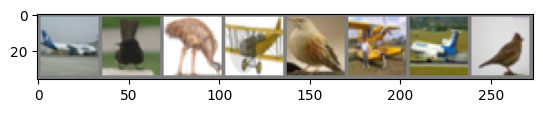

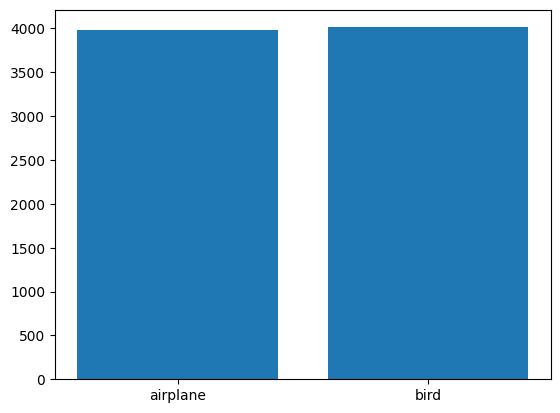

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_example(image_tensor):
    # Unnormalize the pixel color values
    image_tensor = image_tensor * 0.5 + 0.5

    np_image = image_tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    plt.imshow(np_image)
    plt.show()

def show_data_examples():
    missing_labels = [0, 0, 0, 0, 2, 2, 2, 2]
    examples = []
    for images, labels in train_loader:
        if len(missing_labels) == 0: break

        for i in range(len(labels)):
            label = labels[i].item()

            if len(missing_labels) == 0: break
            if label not in missing_labels: continue

            examples.append(images[i])
            missing_labels.remove(label)

    show_data_example(torchvision.utils.make_grid(examples))

def show_label_distribution():
    distribution = {label: 0 for label in INCLUDED_LABELS}
    for _, labels in train_loader:
        for label in labels:
            label_name = CIFAR10_LABELS[label.item()]
            distribution[label_name] += 1

    plt.bar(distribution.keys(), distribution.values())
    plt.show()

show_data_examples()
show_label_distribution()

# Dataset
The first image shows us `4` examples of each label.

The second image shows us that there is a perfect distribution of labels in the training set.

In [186]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.input = nn.Linear(3 * 32 * 32, 512)
        self.hidden1 = nn.Linear(512, 128)
        self.hidden2 = nn.Linear(128, 32)
        self.hidden3 = nn.Linear(32, 2)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.hidden3(x)
        x = torch.flatten(x, 1)
        return x

In [187]:
def compute_loss(model, X, y_true, loss_function):
    # Map the labels to neurons
    # Label 0 (airplane) -> Neuron 0
    # Label 2 (bird) -> Neuron 1
    y_true = torch.Tensor([[1.0, 0.0] if i.item() == 0 else [0.0, 1.0] for i in y_true])

    y_pred = model(X)

    return loss_function(y_pred, y_true)

def train(epoch_count, optimizer, model, loss_function, train_loader):

    for epoch in range(1, epoch_count + 1):

        # We aggregate the loss to print after each epoch
        # This is only for debugging purposes
        epoch_loss = 0.0
        epoch_size = 0

        for X, y_true in train_loader:

            # Reset model gradients
            optimizer.zero_grad()
            
            # Compute loss and gradients
            loss = compute_loss(model, X, y_true, loss_function)
            loss.backward()

            # Update weights
            optimizer.step()

            epoch_loss += loss.item()
            epoch_size += 1

        # Print loss after some epochs
        # This is for debugging purposes
        if epoch == 1 or epoch % 5 == 0:
            print(f'Epoch {epoch} | Training loss: {epoch_loss / epoch_size}')

In [188]:
def train_manual_update(epoch_count, model, loss_function, learning_rate, momentum, weight_decay):

    momentum_buffer = [None for param in model.parameters()]

    for epoch in range(1, epoch_count + 1):

        # We aggregate the loss to print after each epoch
        # This is only for debugging purposes
        epoch_loss = 0.0
        epoch_size = 0

        for X, y_true in train_loader:

            # Reset model gradients
            model.zero_grad()

            # Compute loss and gradients
            loss = compute_loss(model, X, y_true, loss_function)
            loss.backward()
            
            # Update weights
            manual_sgd_step(model, learning_rate, momentum, weight_decay, momentum_buffer)

            epoch_loss += loss.item()
            epoch_size += 1

        # Print loss after some epochs
        # This is for debugging purposes
        if epoch == 1 or epoch % 5 == 0:
            print(f'Epoch {epoch} | Training loss: {epoch_loss / epoch_size}')

def manual_sgd_step(model, learning_rate, momentum, weight_decay, momentum_buffer):
    # A single step of SGD
    # Ref: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    # Ref: https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD
    with torch.no_grad():
        for i, param in enumerate(model.parameters()):
            gradient = param.grad

            # Apply L2 regularization
            if weight_decay != 0:
                gradient = gradient.add(param, alpha=weight_decay)

            # Apply momentum
            if momentum != 0:
                velocity = momentum_buffer[i]
                if velocity is None:
                    # Initialize the velocity as the gradient, not as zero
                    velocity = torch.clone(gradient).detach()
                    momentum_buffer[i] = velocity
                else:
                    velocity.mul_(momentum).add_(gradient)

                gradient = velocity
            
            # Update parameters
            param.add_(gradient, alpha=-learning_rate)

In [189]:
def compute_accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y_true in test_loader:
            y_pred = model(X)

            # Pick the class with the highest probability
            value, y_pred = torch.max(y_pred.data, 1)
            
            # Map the predicted neurons to labels:
            # Neuron 0 -> Label 0 (airplane)
            # Neuron 1 = Label 2 (bird)
            y_pred = torch.tensor([CIFAR10_LABELS.index(INCLUDED_LABELS[i.item()]) for i in y_pred])

            # Update the score
            total += y_true.size(0)
            correct += (y_pred == y_true).sum().item()

    return correct / total

def train_and_eval(loss_function, learning_rate, momentum, weight_decay):
    print("")
    print("=========================================================")
    print("Current parameters:")
    print(f"Learning rate: {learning_rate}")
    print(f"Momentum: {momentum}")
    print(f"Weight decay: {weight_decay}")

    model_sgd = MyMLP()
    model_manual = MyMLP()

    # Copy the initial weights to the manual model
    model_manual.load_state_dict(model_sgd.state_dict())

    print("")
    print("--------- Using Pytorch's SGD ---------")

    optimizer = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    train(EPOCH_COUNT, optimizer, model_sgd, loss_function, train_loader)

    accuracy_sgd = compute_accuracy(model_sgd, val_loader)
    print("")
    print("--- Accuracies ---")
    print(f"Training accuracy: {compute_accuracy(model_sgd, train_loader)}")
    print(f"Validation accuracy: {accuracy_sgd}")

    print("")
    print("--------- Using manual update ----------")

    train_manual_update(EPOCH_COUNT, model_manual, loss_function, learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay)

    accuracy_manual = compute_accuracy(model_manual, val_loader)
    print("")
    print("--- Accuracies ---")
    print(f"Training accuracy: {compute_accuracy(model_manual, train_loader)}")
    print(f"Validation accuracy: {accuracy_manual}")

    # Return the best model and accuracy
    sgd = (model_sgd, accuracy_sgd)
    manual = (model_manual, accuracy_manual)
    return sgd if accuracy_sgd >= accuracy_manual else manual

In [190]:
hyper_parameters = [
    {'learning_rate': .01, 'momentum': .0, 'weight_decay': .000},
    {'learning_rate': .10, 'momentum': .0, 'weight_decay': .000},
    {'learning_rate': .01, 'momentum': .0, 'weight_decay': .010},
    {'learning_rate': .01, 'momentum': .9, 'weight_decay': .000},
    {'learning_rate': .01, 'momentum': .9, 'weight_decay': .010},
    {'learning_rate': .01, 'momentum': .9, 'weight_decay': .001},
    {'learning_rate': .01, 'momentum': .8, 'weight_decay': .010},
    {'learning_rate': .10, 'momentum': .9, 'weight_decay': .010},
    {'learning_rate': .10, 'momentum': .9, 'weight_decay': .001},
    {'learning_rate': .10, 'momentum': .9, 'weight_decay': .010},
    {'learning_rate': .90, 'momentum': .9, 'weight_decay': .010},
]

loss_function = nn.CrossEntropyLoss()

print("Global parameters:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epoch count: {EPOCH_COUNT}")
print(f"Loss function: {loss_function}")
print(f"Seed: {RANDOM_SEED}")

best_accuracy = -1
best_model = None
best_params = None

for params in hyper_parameters:
    model, accuracy = train_and_eval(loss_function, params['learning_rate'], params['momentum'], params['weight_decay'])

    # Keep track of the best model on the validation set
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

print("")
print("=========================================================")
print("Best parameters:")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Momentum: {best_params['momentum']}")
print(f"Weight decay: {best_params['weight_decay']}")

# Show accuracy on unseen test data
test_accuracy = compute_accuracy(best_model, test_loader)
print(f"Test accuracy: {test_accuracy}")

Global parameters:
Batch size: 256
Epoch count: 30
Loss function: CrossEntropyLoss()
Seed: 265

Current parameters:
Learning rate: 0.01
Momentum: 0.0
Weight decay: 0.0

--------- Using Pytorch's SGD ---------
Epoch 1 | Training loss: 0.6901844037519094
Epoch 5 | Training loss: 0.6311858781523557
Epoch 10 | Training loss: 0.5347327487664789
Epoch 15 | Training loss: 0.47947322716175067
Epoch 20 | Training loss: 0.4542207626421308
Epoch 25 | Training loss: 0.4330152388355903
Epoch 30 | Training loss: 0.4116433263563064

--- Accuracies ---
Training accuracy: 0.8345
Validation accuracy: 0.804

--------- Using manual update ----------
Epoch 1 | Training loss: 0.6901844037519094
Epoch 5 | Training loss: 0.6311858781523557
Epoch 10 | Training loss: 0.5347327487664789
Epoch 15 | Training loss: 0.47947322716175067
Epoch 20 | Training loss: 0.4542207626421308
Epoch 25 | Training loss: 0.4330152388355903
Epoch 30 | Training loss: 0.4116433263563064

--- Accuracies ---
Training accuracy: 0.8345
Va